In [1]:
import os
import getpass

from datasets import load_dataset
from huggingface_hub import login
from transformers import AutoTokenizer
from dotenv import load_dotenv
import matplotlib.pyplot as plt


In [2]:

load_dotenv('.envrc')
if 'HF_TOKEN' in os.environ:
    login(token=os.environ['HF_TOKEN'])
else:
    login(token=getpass.getpass('Huggingface token: '))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
DATASET_REPO = 'roneneldan/TinyStories'
STORY_KEY = 'text'
# DATASET_REPO = 'SimpleStories/SimpleStories'
# STORY_KEY = 'story'

TOKENIZER_MODEL = 'SimpleStories/SimpleStories-35M'
VALIDATION_SPLIT_PERCENTAGE = 4

In [4]:

dataset = load_dataset(DATASET_REPO, split='train')
print('Total rows:', len(dataset))


Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Total rows: 2119719


In [5]:
# tokenize the dataset  
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples[STORY_KEY], truncation=False, padding='do_not_pad')
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)


Map:   0%|          | 0/2119719 [00:00<?, ? examples/s]

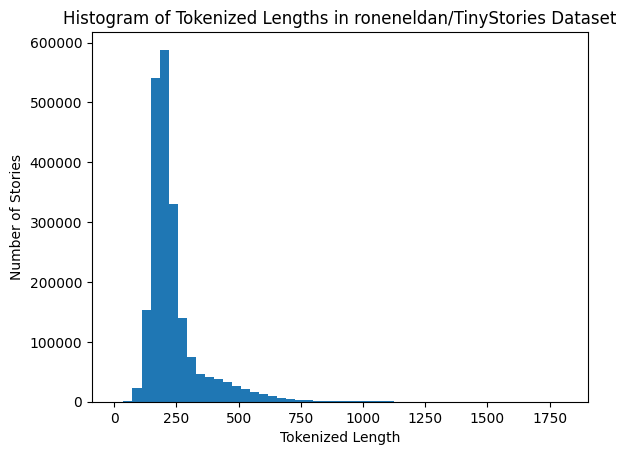

In [6]:
# Historgram of tokenized lengths
lengths = [len(x) for x in tokenized_dataset['input_ids']]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Length')
plt.ylabel('Number of Stories')
plt.title(f'Histogram of Tokenized Lengths in {DATASET_REPO} Dataset')
plt.show()

In [7]:
for thresh in [64, 128, 256, 512]:
    x = sum(l >= thresh for l in lengths) / len(lengths) * 100
    print(f"{x}% of stories are at least {thresh} tokens")

99.97881794709582% of stories are at least 64 tokens
96.79032928421172% of stories are at least 128 tokens
22.471421919603497% of stories are at least 256 tokens
3.839895759768158% of stories are at least 512 tokens


In [8]:
CHUNK_LENGTH = 128
def chunk_dataset_with_map(dataset, token_column='input_ids', chunk_length=CHUNK_LENGTH):
    """
    Memory-efficient version using dataset.map() and batched processing.
    """
    
    def chunk_batch(batch):
        chunked_batch = {col: [] for col in batch.keys()}
        
        for i in range(len(batch[token_column])):
            tokens = batch[token_column][i]
            token_count = len(tokens)
            num_chunks = token_count // chunk_length
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_length
                end_idx = start_idx + chunk_length
                chunk_tokens = tokens[start_idx:end_idx]
                
                # Add chunk to batch
                for col in batch.keys():
                    if col == token_column:
                        chunked_batch[col].append(chunk_tokens)
                    else:
                        chunked_batch[col].append(batch[col][i])
        
        return chunked_batch
    
    # Use map with batched=True for memory efficiency
    chunked_dataset = dataset.map(
        chunk_batch,
        batched=True,
        remove_columns=dataset.column_names,  # Remove original columns
        batch_size=1000,  # Adjust based on your memory constraints
    )
    
    return chunked_dataset
chunked_dataset = chunk_dataset_with_map(tokenized_dataset, chunk_length=CHUNK_LENGTH)

Map:   0%|          | 0/2119719 [00:00<?, ? examples/s]

In [9]:
print(f"The chunked dataset is {len(chunked_dataset)/len(tokenized_dataset) * 100}% of the original dataset length")
total_tokens_chunked = len(chunked_dataset)*CHUNK_LENGTH/1e6
total_tokens_original = sum(lengths)/1e6
print(f"Total available tokens = {total_tokens_original}M tokens")
print(f"Total tokens in chunked dataset = {total_tokens_chunked}M tokens")
print(f"We are left with {total_tokens_chunked/total_tokens_original * 100}% of the original tokens")

The chunked dataset is 134.58279139829384% of the original dataset length
Total available tokens = 495.917955M tokens
Total tokens in chunked dataset = 365.155456M tokens
We are left with 73.63223136375451% of the original tokens


In [10]:
split_dataset = chunked_dataset.train_test_split(test_size=VALIDATION_SPLIT_PERCENTAGE/100)
print(f"Train set size: {len(split_dataset['train'])} samples")
print(f"Validation set size: {len(split_dataset['test'])} samples")
split_dataset.push_to_hub(f"MikiV/{DATASET_REPO.replace('/', '-')}-chunked-{CHUNK_LENGTH}", private=True)

# chunked_dataset.push_to_hub(f"MikiV/{DATASET_REPO.replace('/', '-')}-chunked-{CHUNK_LENGTH}", private=True)


Train set size: 2738665 samples
Validation set size: 114112 samples


Uploading the dataset shards:   0%|          | 0/7 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/368 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/MikiV/roneneldan-TinyStories-chunked-128/commit/565aba20ea3ac50c5703f72f4262d6648825b0c1', commit_message='Upload dataset', commit_description='', oid='565aba20ea3ac50c5703f72f4262d6648825b0c1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MikiV/roneneldan-TinyStories-chunked-128', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MikiV/roneneldan-TinyStories-chunked-128'), pr_revision=None, pr_num=None)

In [11]:
tokenizer.get_vocab()

{'gem': 1576,
 'streams': 3870,
 'fade': 1706,
 '##x': 82,
 'return': 1214,
 '##iet': 740,
 'clues': 2378,
 '##mb': 1218,
 '##akes': 2499,
 'wra': 1758,
 'butter': 1368,
 'back': 315,
 'oh': 1862,
 'logic': 3157,
 '##imm': 832,
 'remembered': 724,
 'or': 736,
 'shown': 2415,
 'wel': 1442,
 '##mos': 3934,
 'spilled': 3713,
 'small': 347,
 'unea': 3336,
 'within': 1289,
 'birthday': 3378,
 'long': 654,
 'sank': 2238,
 'ama': 1060,
 'jelly': 3483,
 'could': 219,
 'fading': 2381,
 'crown': 1899,
 'heads': 3632,
 'drag': 895,
 'townspeople': 3648,
 'giant': 761,
 'remind': 957,
 'darkness': 1227,
 'item': 3216,
 'shine': 1471,
 'sounds': 1506,
 'ar': 277,
 'rabbits': 3428,
 'parrot': 2895,
 'eyes': 349,
 '##itude': 3294,
 'dive': 3398,
 '##its': 3954,
 'vill': 568,
 'grinned': 2350,
 'ele': 3517,
 'easy': 2804,
 'sandw': 3406,
 'mask': 3520,
 '##oot': 2395,
 'invite': 3204,
 '##rot': 2418,
 '##ested': 1547,
 '##found': 2487,
 'knowledge': 2158,
 '##oring': 3123,
 'washed': 2560,
 '##ter': 1

In [12]:
# Ove chunked dataset, find the most common tokens and what percentage of the dataset they cover
from collections import Counter
all_tokens = [token for chunk in chunked_dataset['input_ids'] for token in chunk]
token_counts = Counter(all_tokens)
total_tokens = len(all_tokens)
most_common = token_counts.most_common(20)
for token, count in most_common:
    print(f"Token: {token} ({tokenizer.decode([token])}), Count: {count}, Percentage: {count/total_tokens*100:.2f}%")

Token: 15 (.), Count: 26849526, Percentage: 7.35%
Token: 85 (the), Count: 14327311, Percentage: 3.92%
Token: 13 (,), Count: 13466369, Percentage: 3.69%
Token: 94 (and), Count: 12801332, Percentage: 3.51%
Token: 93 (to), Count: 10735799, Percentage: 2.94%
Token: 32 (a), Count: 9740562, Percentage: 2.67%
Token: 3 ("), Count: 7993955, Percentage: 2.19%
Token: 127 (was), Count: 7109041, Percentage: 1.95%
Token: 103 (he), Count: 6122277, Percentage: 1.68%
Token: 106 (she), Count: 5986760, Percentage: 1.64%
Token: 120 (it), Count: 5449733, Percentage: 1.49%
Token: 111 (they), Count: 4548122, Percentage: 1.25%
Token: 117 (her), Count: 3584230, Percentage: 0.98%
Token: 8 ('), Count: 3194868, Percentage: 0.87%
Token: 197 (said), Count: 2725037, Percentage: 0.75%
Token: 108 (in), Count: 2518577, Percentage: 0.69%
Token: 593 (lily), Count: 2480913, Percentage: 0.68%
Token: 165 (you), Count: 2478539, Percentage: 0.68%
Token: 65 (##s), Count: 2375897, Percentage: 0.65%
Token: 461 (mom), Count: 2369